# Online inference / ridge regression

In [60]:
import jax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

In [61]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

In [62]:
key = jax.random.PRNGKey(314)
key_x, key_y, key_coef, key_samples = jax.random.split(key, 4)

In [63]:
m = 2
n_test = 200
n_samples = 500 + n_test

# coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8])
X = jax.random.uniform(key_x, (n_samples, m))
errs = jax.random.normal(key_y, (n_samples,))
y = jnp.einsum("sm,m->s", X, coefs) + errs
y = jnp.atleast_2d(y).T

In [64]:
X_test = X[-n_test:]
y_test = y[-n_test:]

X = X[:-n_test]
y = y[:-n_test]

In [65]:
alpha = 1.0
mu_ridge = jnp.linalg.solve(X.T @ X + jnp.eye(m) * alpha, X.T @ y)

In [66]:
r = 1.0

I = jnp.eye(m)
def step(coef, xs):
    mu, cov = coef
    y, x, = xs
    
    S = x.T @ cov @ x + r
    K = cov @ x @ jnp.linalg.inv(S)

    err = (y - mu.T @ x)
    mu = mu + K @ err
    cov = (I - K @ x.T) @ cov

    return (mu, cov), (mu, cov, err)

In [67]:
params = (jnp.zeros(m), I)
(mu, cov), (mu_vals, cov_vals, err) = jax.lax.scan(step, params, (y, X[..., None]))

In [68]:
width, height = 6.4 * 1.3, 4.8 * 0.6

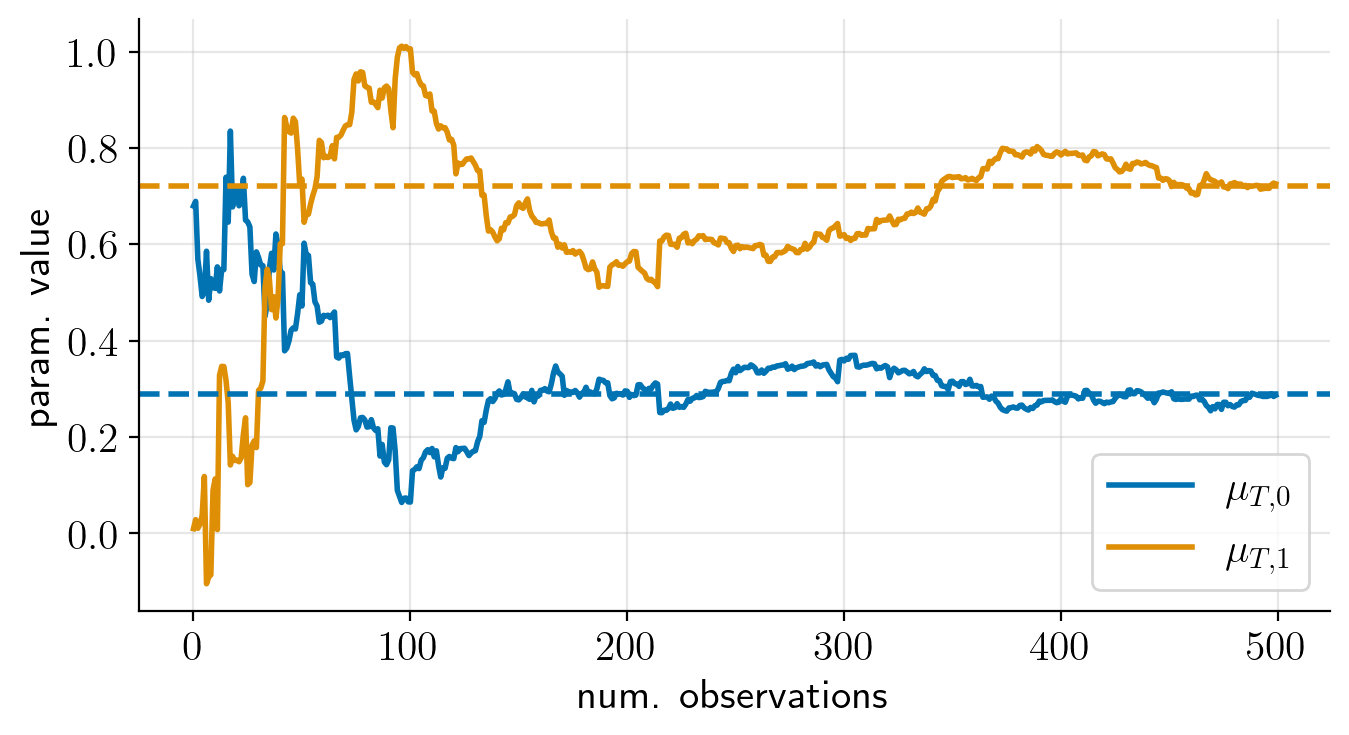

In [69]:
# fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.9))
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.8))

plt.plot(mu_vals, label=[r"$\mu_{T,0}$", r"$\mu_{T,1}$"])
for i, p in enumerate(mu_ridge):
    color = sns.color_palette()[i]
    plt.axhline(p, color=color, linestyle="--")

plt.legend()
plt.ylabel("param. value")
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

plt.savefig("../figures/recursive-ridge-online-params.png", dpi=300, bbox_inches="tight")

In [72]:
errs_rolling = np.sqrt(np.power((mu_vals @ X_test.T) - y_test.T, 2).mean(axis=-1))
rmse_ridge = np.sqrt(np.power((X_test @ mu_ridge).squeeze() - y_test.squeeze(), 2).mean())

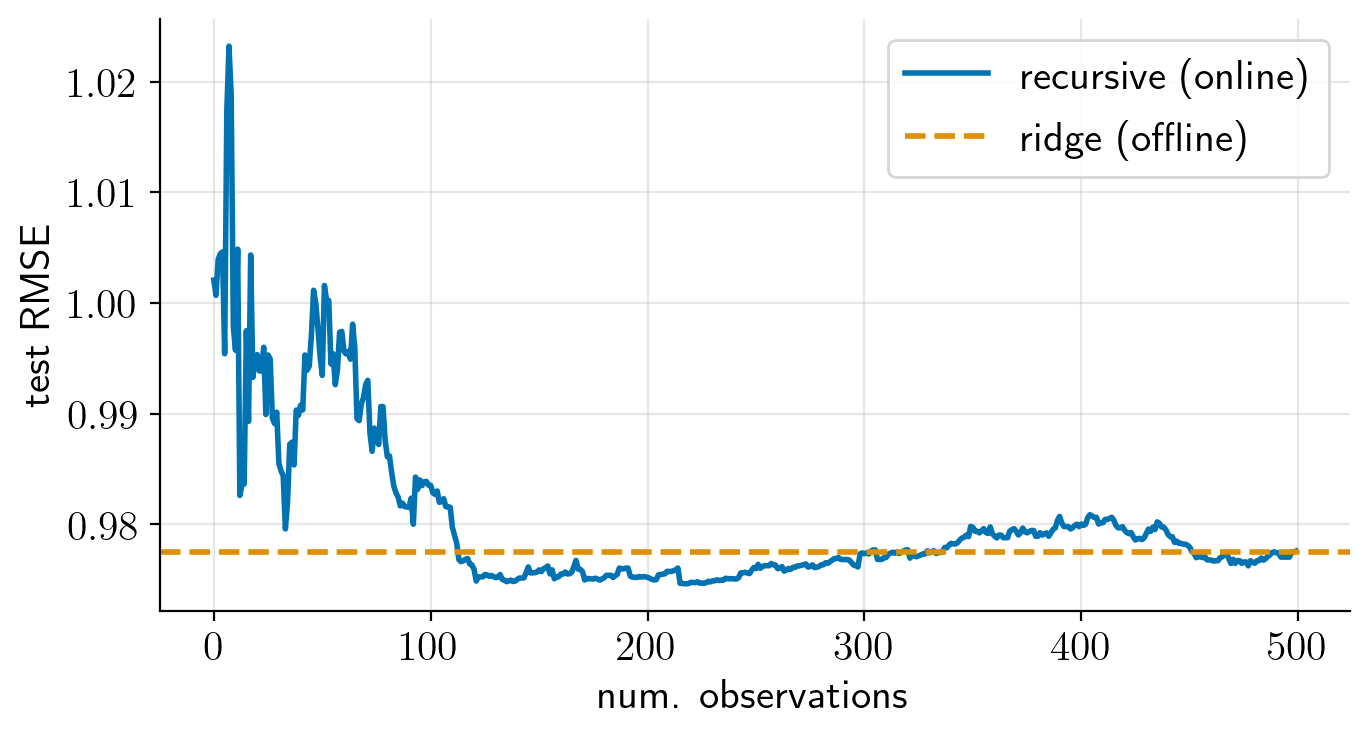

In [71]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.8))

plt.plot(errs_rolling, c=palette[0], label="recursive (online)")
plt.axhline(y=rmse_ridge, c=palette[1], label="ridge (offline)", linestyle="--")
plt.ylabel("test RMSE")
plt.xlabel("num. observations")
# plt.ylim(0.8, 1.2)
plt.legend()
# plt.xlim(right=n_samples)
plt.grid(alpha=0.3)
plt.savefig("../figures/recursive-rmse-test.png", dpi=300, bbox_inches="tight")

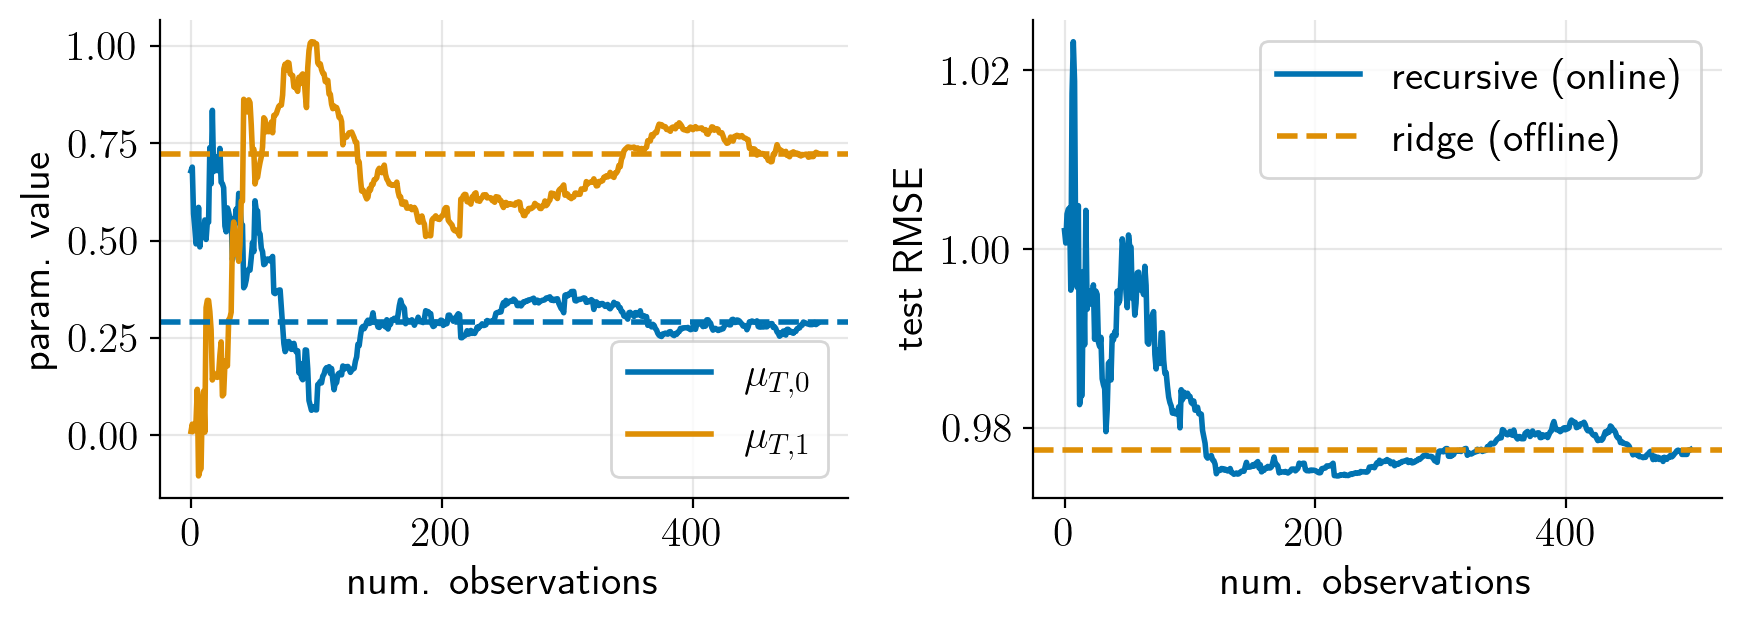

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(6.4 * 1.4, 4.8 * 0.7))

plt.sca(axs[0])
plt.plot(mu_vals, label=[r"$\mu_{T,0}$", r"$\mu_{T,1}$"])
for i, p in enumerate(mu_ridge):
    color = sns.color_palette()[i]
    plt.axhline(p, color=color, linestyle="--")

plt.legend()
plt.ylabel("param. value")
plt.xlabel("num. observations")
plt.grid(alpha=0.3)


plt.sca(axs[1])
plt.plot(errs_rolling, c=palette[0], label="recursive (online)")
plt.axhline(y=rmse_ridge, c=palette[1], label="ridge (offline)", linestyle="--")
plt.ylabel("test RMSE")
plt.xlabel("num. observations")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/recursive-param-and-ohe-rmse.png", dpi=300, bbox_inches="tight")

## Multiple simulations

In [137]:
# m = 20
n_test = 200
n_samples = 500 + n_test

# coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8])

x = jax.random.uniform(key_x, (n_samples, 1), minval=-2, maxval=4) # m
X = jnp.c_[np.ones_like(x), x, x ** 2, x ** 3]
coefs = jnp.array([0.1, 0.5, -0.2, 0.05])
_, m = X.shape
errs = jax.random.normal(key_y, (n_samples,)) * 0.3
y = jnp.einsum("sm,m->s", X, coefs) + errs
y = jnp.atleast_2d(y).T

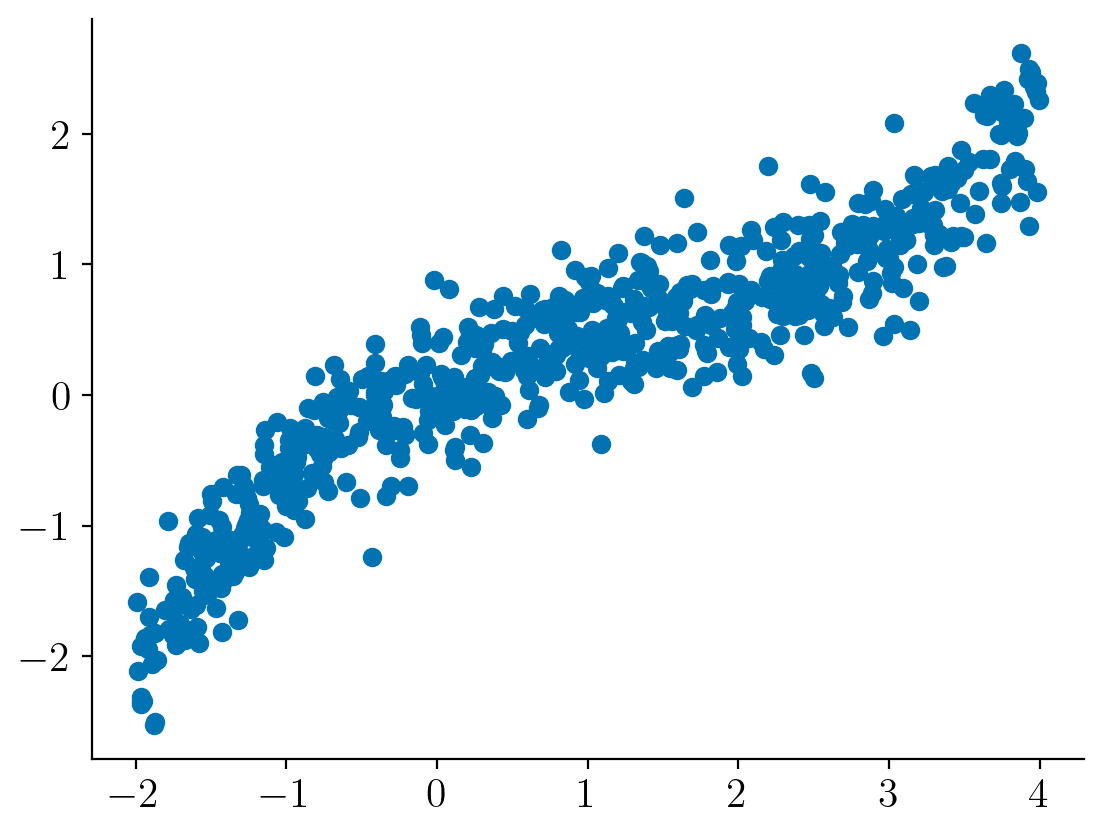

In [138]:
plt.scatter(x, y)

In [139]:
X_test = X[-n_test:]
y_test = y[-n_test:]

X = X[:-n_test]
y = y[:-n_test]

In [152]:
def step(coef, xs):
    mu, cov = coef
    y, x, = xs
    
    S = x.T @ cov @ x + r
    K = cov @ x @ jnp.linalg.inv(S)

    yhat = mu.T @ x
    err = (y - yhat)
    mu = mu + K @ err
    cov = (I - K @ x.T) @ cov

    # import pdb; pdb.set_trace()
    return (mu, cov), (mu, cov, err, yhat)

In [156]:
@jax.jit
@partial(jax.vmap, in_axes=(0, None, None, None, None), out_axes=-1)
def shuffle_and_run(key, X, y, mean_init, cov_init):
    params = mean_init, cov_init
    ixs = jax.random.choice(key, n_samples, (n_samples,))
    X_shuffle = X[ixs]
    y_shuffle = y[ixs]

    (mu, cov), (mu_vals, cov_vals, err, yhat) = jax.lax.scan(step, params, (y_shuffle, X_shuffle[..., None]))
    return err, yhat

In [161]:
n_trials = 30
mean_init = jnp.zeros(m)
cov_init = I = jnp.eye(m)

keys_runs = jax.random.split(key_samples, n_trials)
errs_runs, yhat = shuffle_and_run(keys_runs, X, y, mean_init, cov_init)
errs_runs = pd.DataFrame(np.array(errs_runs).squeeze())
yhat = yhat.squeeze()

<Axes: >

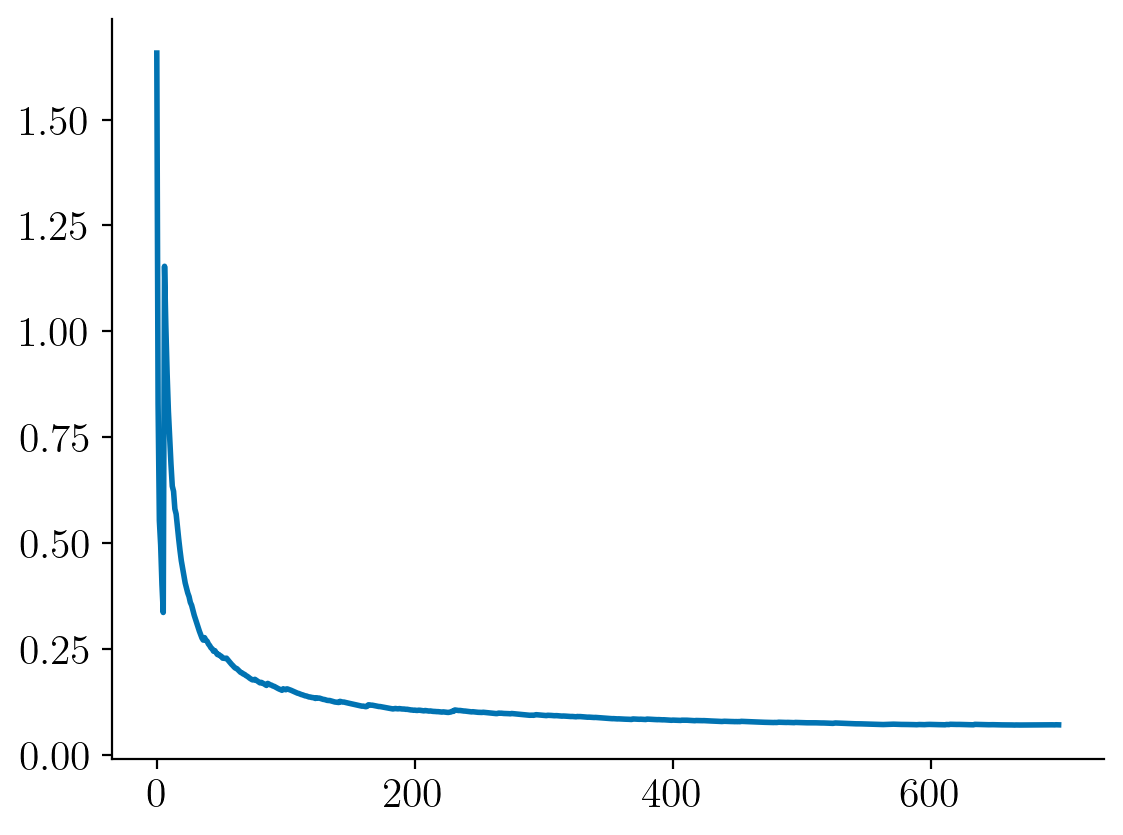

In [150]:
np.power(errs_runs[0], 2).expanding().mean().plot()

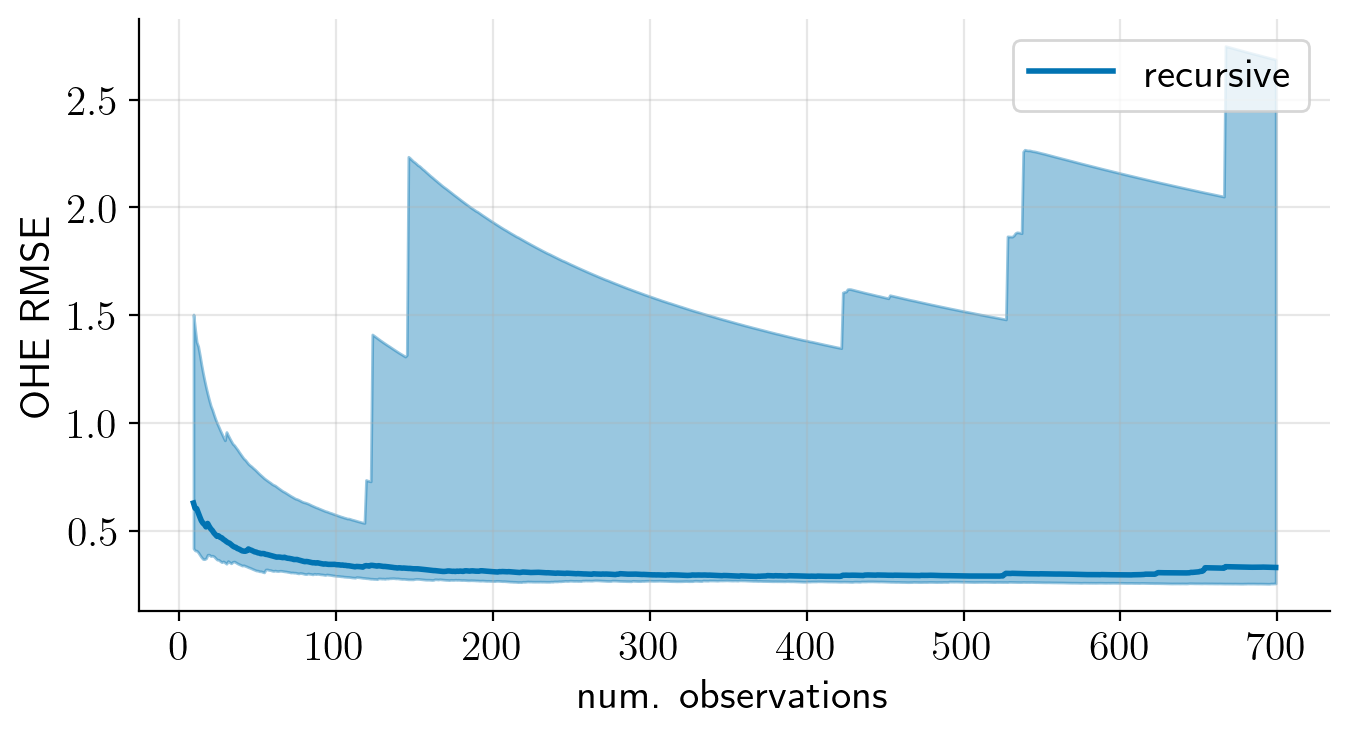

In [143]:
expanding_errs = np.sqrt(np.power(errs_runs, 2).expanding(10).mean())
# expanding_errs = errs_runs.copy()

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.8))

lbound = expanding_errs.quantile(0.05, axis=1)
ubound = expanding_errs.quantile(0.95, axis=1)

plt.fill_between(lbound.index, lbound, ubound, color=palette[0], alpha=0.4)
expanding_errs.quantile(0.5, axis=1).plot(c=palette[0], label="recursive")
# plt.axhline(y=rmse_ridge, c=palette[1], label="ridge", linestyle="--")
plt.ylabel("OHE RMSE")
plt.xlabel("num. observations")
# plt.ylim(0.8, 1.2)
plt.legend()
# plt.xlim(right=n_samples)
plt.grid(alpha=0.3)
# plt.savefig("../figures/recursive-rmse-ohe.png", dpi=300, bbox_inches="tight")